### Comparación de modelos con distintos conjuntos de variables
-------------


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargar dataset completo
df = pd.read_csv("HR_Em_Attrition_Engineered.csv")

In [3]:
# Target
y = df['Attrition']


In [4]:
# Definición de los tres conjuntos de features
features_model1 = [
    'OverTime_Yes', 'BusinessTravel_Travel_Frequently', 'Log_MonthlyIncome',
    'YearsSinceLastPromotion', 'MaritalStatus_Single', 'NumCompaniesWorked',
    'EnvironmentSatisfaction', 'YearsAtCompany', 'YearsWithCurrManager', 'JobSatisfaction']


####**Modelo 1 – Basado en coeficientes de regresión logística:**
 Se seleccionaron las 10 variables con mayor valor absoluto de coeficiente, lo cual indica mayor influencia directa sobre la probabilidad de rotación. Incluye:

 - OverTime_Yes
 - BusinessTravel_Travel_Frequently
 - Log_MonthlyIncome
 - YearsSinceLastPromotion
 - MaritalStatus_Single
 - NumCompaniesWorked
 - EnvironmentSatisfaction
 - YearsAtCompany
 - YearsWithCurrManager
 - JobSatisfaction

In [5]:
features_model2 = [
    'OverTime_Yes', 'MaritalStatus_Single', 'JobRole_Sales Representative',
    'JobRole_Research Director', 'BusinessTravel_Travel_Frequently',
    'JobRole_Manager', 'JobRole_Manufacturing Director',
    'JobRole_Laboratory Technician', 'MaritalStatus_Married',
    'Department_Research & Development']


**Modelo 2 – Basado en Information Value (IV):**
Se seleccionaron variables con IV > 0.05, lo cual sugiere una capacidad predictiva útil según criterios de selección de variables en modelos de riesgo:
- OverTime_Yes
- MaritalStatus_Single
- JobRole_Sales Representative
- JobRole_Research Director
- BusinessTravel_Travel_Frequently
- JobRole_Manager
- JobRole_Manufacturing Director
- JobRole_Laboratory Technician
- MaritalStatus_Married
- Department_Research & Development

In [6]:

features_model3 = [
    'OverTime_Yes', 'Log_MonthlyIncome', 'JobSatisfaction',
    'YearsWithCurrManager', 'BusinessTravel_Travel_Frequently',
    'JobRole_Manager', 'EnvironmentSatisfaction']

**Modelo 3 – Selección combinada:**
 Este modelo busca un balance entre interpretabilidad, bajo solapamiento (correlación baja entre variables) y contribución significativa según coeficientes e IV. Incluye:
- OverTime_Yes
- Log_MonthlyIncome
- JobSatisfaction
- YearsWithCurrManager
- BusinessTravel_Travel_Frequently
- JobRole_Manager
- EnvironmentSatisfaction

In [7]:
model_sets = {
    'Modelo_1': features_model1,
    'Modelo_2': features_model2,
    'Modelo_3': features_model3
}


In [9]:
# ### Funciones de evaluación

# %%
def evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    ks = max(tpr - fpr)
    cm = confusion_matrix(y_test, y_pred)

    return acc, prec, rec, ks, cm, fpr, tpr

In [12]:
# %%
results = {
    'Baseline': {
        'Accuracy': 0.841, 'Precision': 0.667, 'Recall': 0.028, 'KS': 0.299,
        'ConfusionMatrix': None
    }
}
curves = {}

for name, features in model_sets.items():
    X_subset = df[features]
    acc, prec, rec, ks, cm, fpr, tpr = evaluate_model(X_subset, y)
    results[name] = {
        'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'KS': ks, 'ConfusionMatrix': cm
    }
    curves[name] = (fpr, tpr)


In [13]:
# ### Resultados comparativos

# %%
summary_df = pd.DataFrame(results).T[['Accuracy', 'Precision', 'Recall', 'KS']]
print(summary_df)

          Accuracy Precision    Recall        KS
Baseline     0.841     0.667     0.028     0.299
Modelo_1  0.854875  0.612903  0.267606  0.544918
Modelo_2   0.85034  0.619048  0.183099  0.419718
Modelo_3   0.85941       0.8  0.169014  0.488847


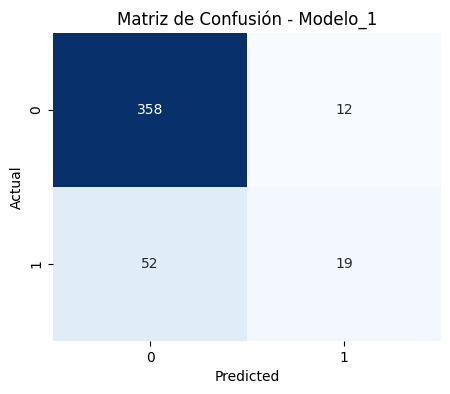

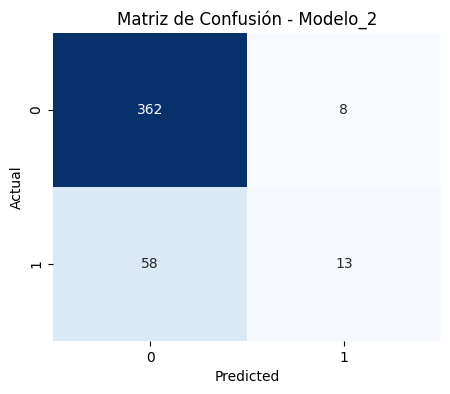

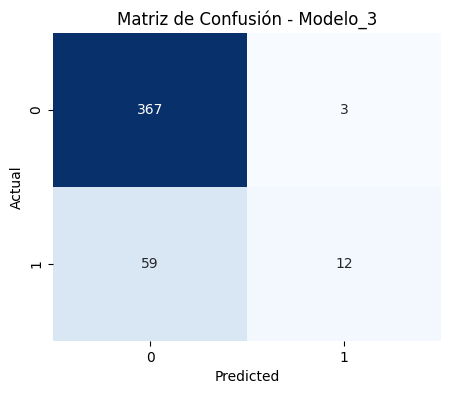

In [18]:
# Mostrar matriz de confusión por modelo
for model_name, metrics in results.items():
    cm = metrics['ConfusionMatrix']
    if cm is not None:
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Matriz de Confusión - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()


### Interpretación de las Matrices de Confusión

| Modelo    | Verdaderos Negativos (TN) | Falsos Positivos (FP) | Falsos Negativos (FN) | Verdaderos Positivos (TP) |
|-----------|---------------------------|-----------------------|-----------------------|---------------------------|
| Modelo 1  | 358                       | 12                    | 52                    | 19                        |
| Modelo 2  | 362                       | 8                     | 58                    | 13                        |
| Modelo 3  | 367                       | 3                     | 59                    | 12                        |

- **Verdaderos Negativos (TN):** Número de empleados que no rotaron y el modelo predijo correctamente.
- **Falsos Positivos (FP):** Número de empleados que no rotaron pero el modelo predijo que sí.
- **Falsos Negativos (FN):** Número de empleados que rotaron pero el modelo predijo que no.
- **Verdaderos Positivos (TP):** Número de empleados que rotaron y el modelo predijo correctamente.

---

### Análisis rápido:

- **Modelo 1:** Tiene un buen equilibrio, con 19 verdaderos positivos y 52 falsos negativos. Esto indica que detecta mejor los casos de rotación en comparación con los otros modelos. Sin embargo, también tiene un número relativamente alto de falsos negativos, es decir, empleados que rotaron y no fueron detectados.

- **Modelo 2:** Mejora ligeramente en falsos positivos (8), pero empeora en verdaderos positivos (13) y falsos negativos (58), mostrando menor capacidad para identificar rotación real.

- **Modelo 3:** Tiene el menor número de falsos positivos (3), pero también el menor número de verdaderos positivos (12), lo que indica que es muy conservador al predecir rotación, priorizando evitar falsos positivos a costa de no detectar algunos casos reales.

---

### Conclusión

El **Modelo 1** ofrece el mejor balance entre detectar empleados que rotan y evitar falsos positivos, siendo el más adecuado si el objetivo es identificar correctamente la mayor cantidad posible de rotaciones para poder actuar sobre ellas. Los otros modelos sacrifican recall para mejorar precisión o reducir falsos positivos, lo que puede ser menos útil en escenarios donde perder casos reales de rotación es costoso.


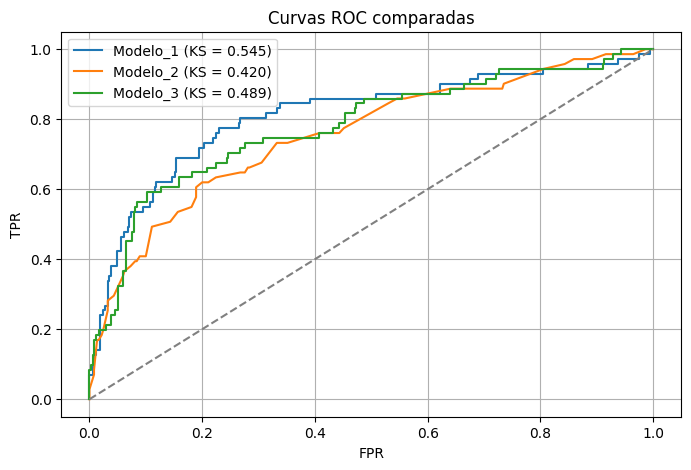

In [14]:
# ### Visualización de la separación KS

# %%
plt.figure(figsize=(8, 5))
for name, (fpr, tpr) in curves.items():
    plt.plot(fpr, tpr, label=f"{name} (KS = {max(tpr - fpr):.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Curvas ROC comparadas")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()

#### Tabla comparativa de resultados

 | Modelo     | Accuracy | Precision | Recall | KS    |
 |------------|----------|-----------|--------|-------|
 | Baseline   | 0.841    | 0.667     | 0.028  | 0.299 |
 | Modelo_1   | 0.855    | 0.613     | 0.268  | 0.545 |
 | Modelo_2   | 0.850    | 0.619     | 0.183  | 0.420 |
 | Modelo_3   | 0.859    | 0.800     | 0.169  | 0.489 |


#### Análisis resumido por modelo
 
**Baseline:** Tiene baja capacidad de detección (recall) y un KS bajo. Sirve como punto de comparación, pero su utilidad práctica es muy limitada.

**Modelo 1:** Balancea bien precisión y recall. Su KS es el más alto, lo que indica buena separación entre clases. Muy recomendado si se busca equilibrio.

**Modelo 2:** Buen desempeño general, pero su recall es más bajo. A pesar de buena precisión, puede dejar escapar muchos casos positivos.

**Modelo 3:** La precisión más alta, ideal para evitar falsos positivos, pero su recall es el más bajo después del baseline.

-------------

## Decisión de Selección del Modelo Final

Después de evaluar los tres modelos desarrollados, se selecciona el **Modelo 1** como la mejor opción para la predicción de rotación de empleados basándonos en los siguientes criterios:

- **Mejor balance entre precisión y recall:**  
  Aunque el Modelo 3 tiene la mayor precisión (0.800), su recall es bajo (0.169), lo que significa que no detecta muchos casos reales de rotación. El Modelo 1 presenta una precisión razonable (0.613) junto con el recall más alto (0.268), lo que permite identificar más empleados que realmente dejarán la empresa.

- **Mayor capacidad de separación (KS):**  
  El Modelo 1 obtuvo el valor más alto de KS (0.545), indicando una mejor separación entre las clases rotación y no rotación comparado con los otros modelos.

- **Matriz de confusión equilibrada:**  
  El Modelo 1 muestra un buen equilibrio entre verdaderos positivos y falsos negativos, detectando más rotaciones reales sin aumentar excesivamente los falsos positivos.

Por lo tanto, el Modelo 1 es el más adecuado para su implementación, especialmente si el objetivo es maximizar la detección temprana de rotación para permitir intervenciones oportunas.

---
